In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

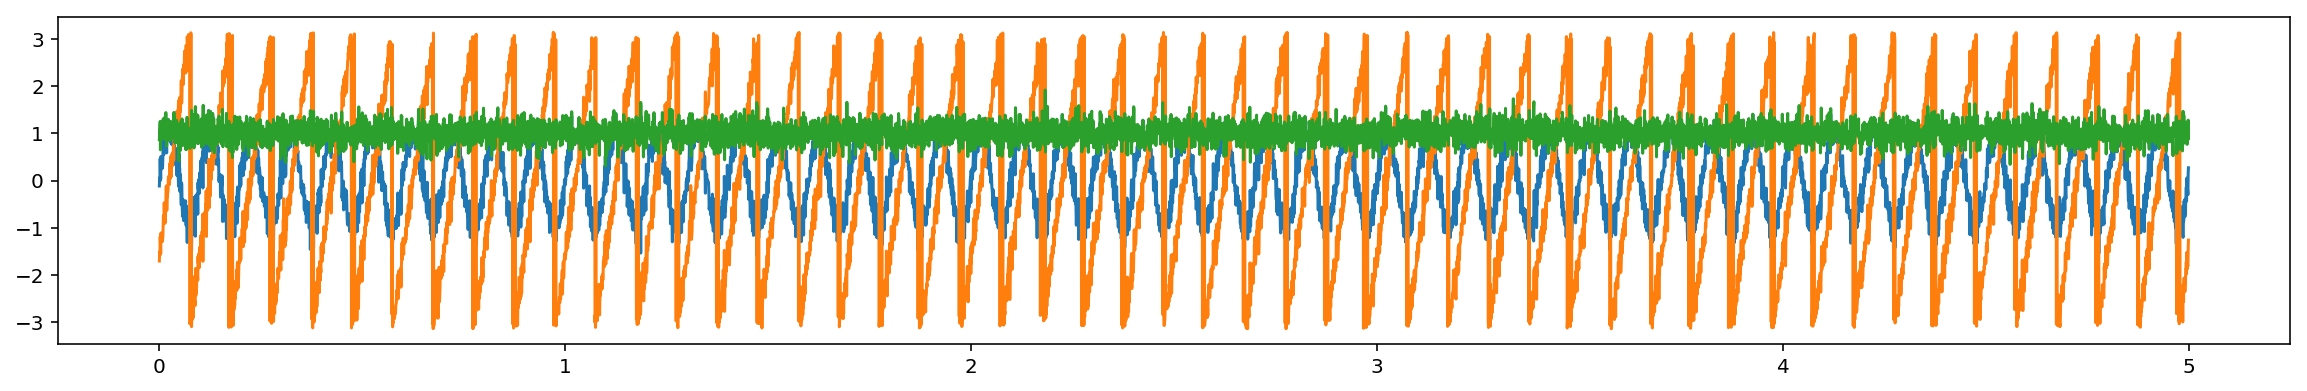

In [88]:
from scipy.signal import filtfilt, remez, hilbert, freqz
from scipy.stats import norm

sampling_frequency = 1500
n_samples = sampling_frequency * 5

time = np.arange(n_samples) / sampling_frequency
lfp = np.sin(2 * np.pi * time * 10) + norm.rvs(scale=0.2, size=time.size)
phase = np.angle(hilbert(lfp))
magnitude = np.abs(hilbert(lfp))

plt.figure(figsize=(20, 3))
plt.plot(time, lfp)
plt.plot(time, phase)
plt.plot(time, magnitude);

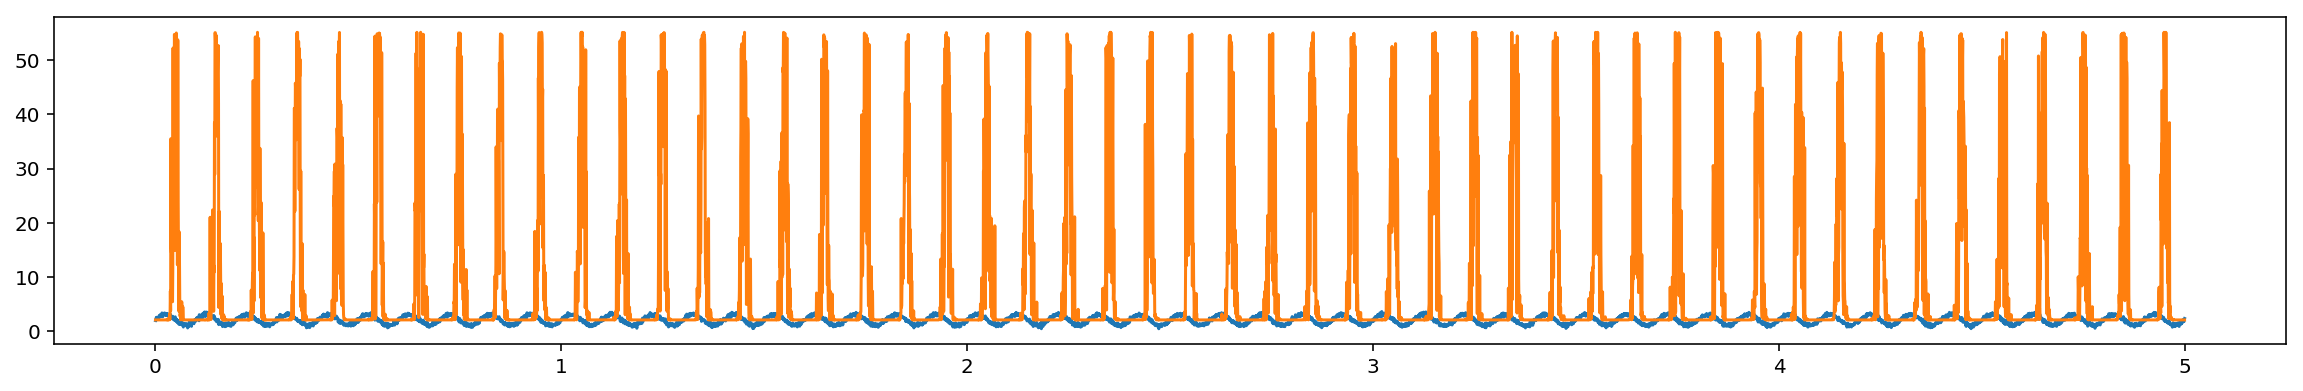

In [104]:
baseline_rate = 2
rate = baseline_rate + 40 * norm(loc=np.pi / 2, scale=0.3).pdf(phase)

plt.figure(figsize=(20, 3))
plt.plot(time, lfp + baseline_rate)
plt.plot(time, rate);

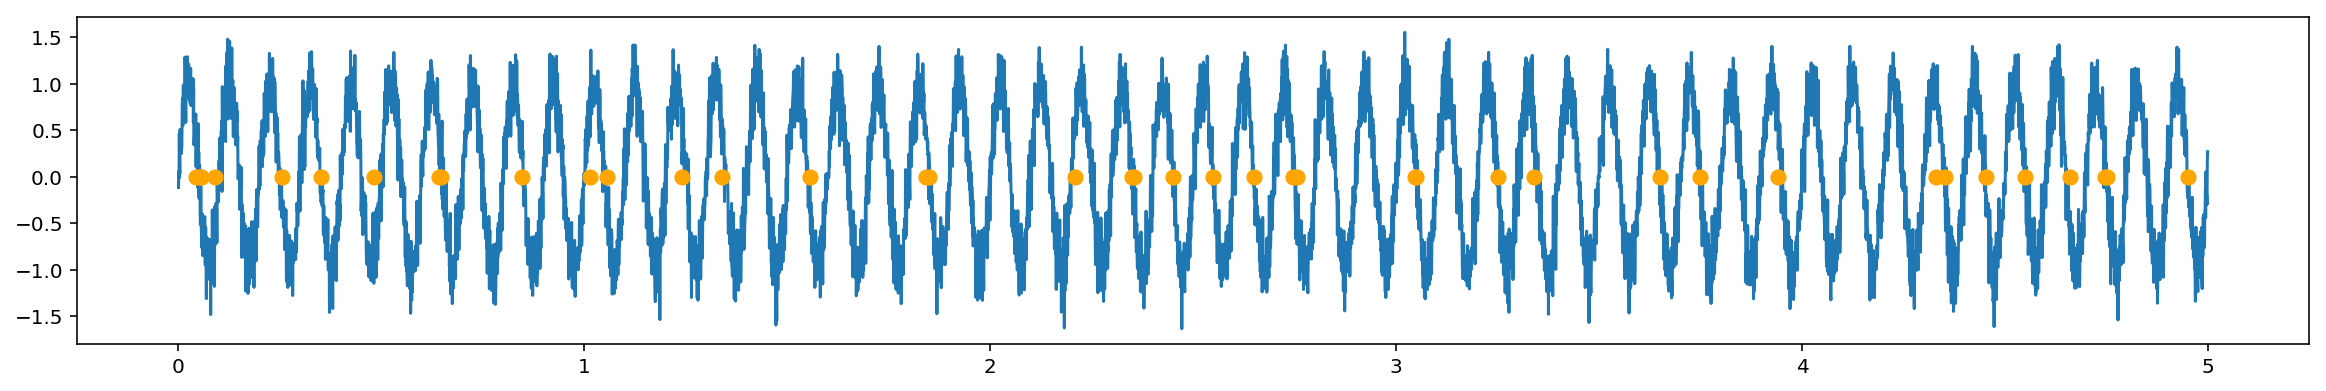

In [106]:
spikes = np.random.poisson(rate / sampling_frequency)
spike_times = time[np.nonzero(spikes)[0]]

plt.figure(figsize=(20, 3))
plt.plot(time, lfp)
plt.scatter(spike_times, np.zeros_like(spike_times), color='orange', zorder=100, s=50)

In [95]:
from scipy.signal import filtfilt, remez, hilbert, freqz

def theta_filter(sampling_frequency):
    ORDER = 1500
    nyquist = 0.5 * sampling_frequency
    TRANSITION_BAND = 2
    THETA_BAND = [6, 12]
    desired = [0, THETA_BAND[0] - TRANSITION_BAND, THETA_BAND[0],
               THETA_BAND[1], THETA_BAND[1] + TRANSITION_BAND, nyquist]
    return remez(ORDER, desired, [0, 1, 0], Hz=sampling_frequency), 1.0

filter_numerator, filter_denominator = theta_filter(sampling_frequency)

In [96]:
theta_filtered = filtfilt(
        filter_numerator, filter_denominator, lfp)

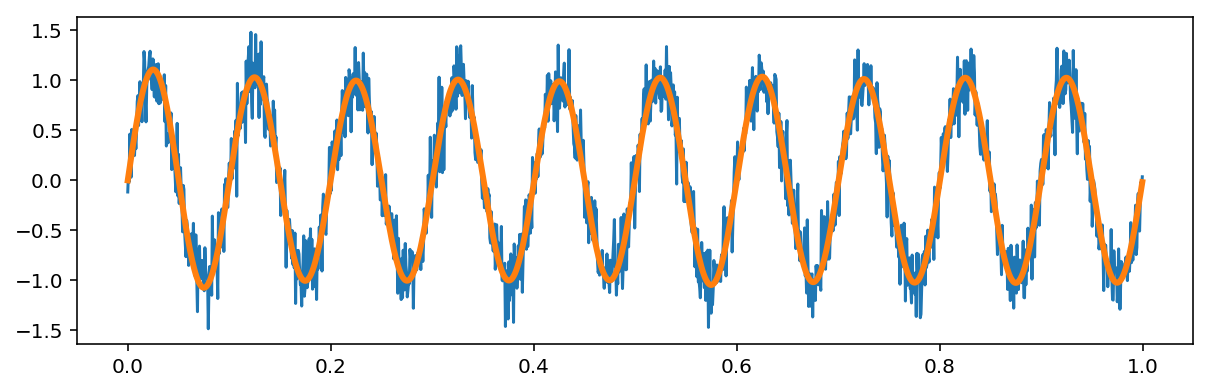

In [103]:
plt.figure(figsize=(10, 3))
plt.plot(time[:1500], lfp[:1500])
plt.plot(time[:1500], theta_filtered[:1500], linewidth=3);

In [107]:

amplitude_envelope = np.abs(analytic_signal)


In [116]:
from patsy import dmatrices

analytic_signal = hilbert(theta_filtered, axis=0)

data = {
    'is_spike': spikes,
    'lfp_instantaneous_phase': np.angle(analytic_signal)
}

formula = 'is_spike ~ 1 + np.cos(lfp_instantaneous_phase) + np.sin(lfp_instantaneous_phase)'

response, design_matrix = dmatrices(formula, data)

design_matrix

DesignMatrix with shape (7500, 3)
  Intercept  np.cos(lfp_instantaneous_phase)  np.sin(lfp_instantaneous_phase)
          1                         -0.00001                         -1.00000
          1                          0.04197                         -0.99912
          1                          0.08401                         -0.99646
          1                          0.12495                         -0.99216
          1                          0.16649                         -0.98604
          1                          0.20671                         -0.97840
          1                          0.24757                         -0.96887
          1                          0.28698                         -0.95794
          1                          0.32689                         -0.94506
          1                          0.36526                         -0.93091
          1                          0.40394                         -0.91479
          1                   

In [170]:
from regularized_glm import penalized_IRLS
from statsmodels.api import families


penalty = np.array([0, 1E-1, 1E-1])
fit = penalized_IRLS(design_matrix, response, family=families.Poisson(), penalty=penalty)

fit.coefficients

/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/regularized_glm/core.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  full_response * full_weights)[0]


array([[-6.45777898],
       [ 0.17718023],
       [ 2.60042834]])

In [171]:
estimated_baseline_rate = np.exp(fit.coefficients[0]) * sampling_frequency
estimated_baseline_rate

array([2.35241253])

In [172]:
spike_field_coherency = fit.coefficients[1] + fit.coefficients[2] * 1j

In [173]:
np.abs(spike_field_coherency)

array([2.60645744])

In [174]:
np.angle(spike_field_coherency)

array([1.50276645])

In [175]:
np.arctan2(fit.coefficients[2], fit.coefficients[1])

array([1.50276645])

In [176]:
np.pi / 2

1.5707963267948966

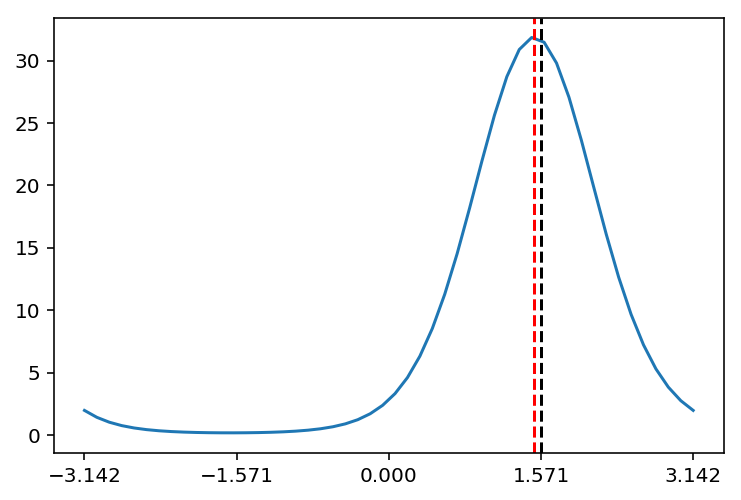

In [184]:
from patsy import build_design_matrices

predict_data = {
    'lfp_instantaneous_phase': np.linspace(-np.pi, np.pi)
}

predict_design_matrix = build_design_matrices(
    [design_matrix.design_info], predict_data)[0]

fig, ax = plt.subplots(1, 1)
ax.plot(np.linspace(-np.pi, np.pi), np.exp(predict_design_matrix @ fit.coefficients) * sampling_frequency);
ax.set_xticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
ax.axvline(np.pi/2, linestyle='--', color='black')
ax.axvline(np.angle(spike_field_coherency), linestyle='--', color='red');

In [185]:
from patsy import dmatrices

analytic_signal = hilbert(theta_filtered, axis=0)

data = {
    'is_spike': spikes,
    'lfp_instantaneous_phase': np.angle(analytic_signal)
}

formula = 'is_spike ~ 1 + bs(lfp_instantaneous_phase, df=5)'

response, design_matrix = dmatrices(formula, data)

design_matrix

DesignMatrix with shape (7500, 6)
  Columns:
    ['Intercept',
     'bs(lfp_instantaneous_phase, df=5)[0]',
     'bs(lfp_instantaneous_phase, df=5)[1]',
     'bs(lfp_instantaneous_phase, df=5)[2]',
     'bs(lfp_instantaneous_phase, df=5)[3]',
     'bs(lfp_instantaneous_phase, df=5)[4]']
  Terms:
    'Intercept' (column 0)
    'bs(lfp_instantaneous_phase, df=5)' (columns 1:6)
  (to view full data, use np.asarray(this_obj))

In [187]:
from regularized_glm import penalized_IRLS
from statsmodels.api import families


penalty = np.ones((design_matrix.shape[1],)) * 1E-1
penalty[0] = 0
fit = penalized_IRLS(design_matrix, response, family=families.Poisson(), penalty=penalty)

fit.coefficients

/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/regularized_glm/core.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  full_response * full_weights)[0]


array([[-7.10260684],
       [ 1.42128163],
       [-2.2624659 ],
       [ 3.47822123],
       [ 4.66670292],
       [-6.12814889]])

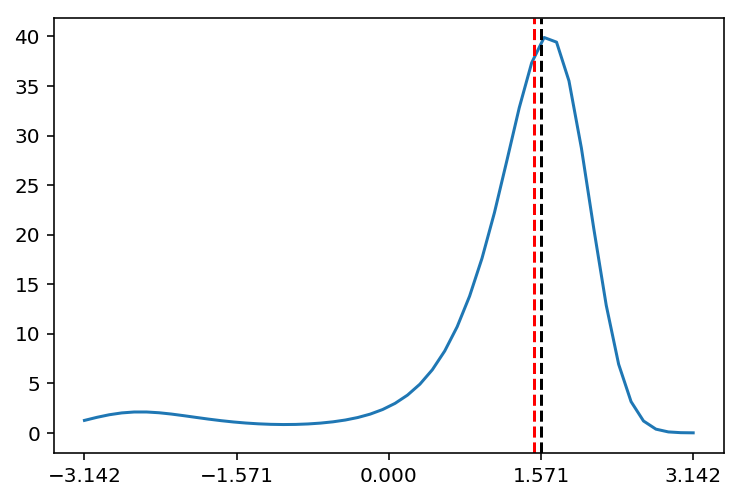

In [192]:
from patsy import build_design_matrices

predict_data = {
    'lfp_instantaneous_phase': np.linspace(-np.pi+0.01, np.pi-0.01)
}

predict_design_matrix = build_design_matrices(
    [design_matrix.design_info], predict_data)[0]

fig, ax = plt.subplots(1, 1)
ax.plot(np.linspace(-np.pi, np.pi), np.exp(predict_design_matrix @ fit.coefficients) * sampling_frequency);
ax.set_xticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
ax.axvline(np.pi/2, linestyle='--', color='black')
ax.axvline(np.angle(spike_field_coherency), linestyle='--', color='red');